In [1]:
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import warnings
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn.decomposition import PCA

# Display preferences.
%matplotlib inline
#pd.options.display.float_format = '{:.5f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

# Based on some visual + mathematical concepts, we decided to split the population into 6 levels
def get_population_group(population):   
    if population < 4800:
        return 1
    if population in range(4800, 12500):
        return 2
    if population in range(12500,22500):
        return 3
    if population in range(22500, 46000):
        return 4
    if population > 46000:
        return 5 

def get_population_group_spaced(population):
    0.1, 0.5, 1.0, 2.0, 4.4
    if population < 4800:
        return 0.1
    if population in range(4800, 12500):
        return 0.5
    if population in range(12500,22500):
        return 1.0
    if population in range(22500, 46000):
        return 2.0
    if population > 46000:
        return 4.4

# Data

## Read

In [2]:
# Read in the crime data for Florida for 2016, listed by city
florida_crime = pd.read_excel('./florida_2017.xls')
florida_crime.columns = ['city', 'population', 'violent_crime', 'murder', 'rape', 'robbery',
       'assault', 'property_crime', 'burglary', 'larceny_theft',
       'motor_vehicle_theft', 'arson']
florida_crime.set_index('city', inplace=True)

crime_cols = ['violent_crime', 'murder', 'rape', 'robbery', 
              'assault', 'property_crime', 'burglary', 'larceny_theft', 
              'motor_vehicle_theft', 'arson']
florida_crime = florida_crime[florida_crime.population.between(1180, 128637)]

*There are about 30 outliers when it comes to population, for this exercise we will discard these.*

## Inspect

In [69]:
florida_crime.describe()

,population,violent_crime,murder,rape,robbery,assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,...,population_log,has_murder,has_rape,has_robbery,has_assault,has_property_crime,has_burglary,hss_larceny_theft,has_motor_vehicle_theft,has_arson
count,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000,...,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000
mean,35417.45423,170.28521,2.17254,14.31338,44.07394,109.72535,1129.05986,171.60563,863.82042,93.63380,...,9.43827,0.42606,0.74296,0.82042,0.92254,0.99648,0.98239,0.99296,0.92606,0.49648
std,74789.22599,467.35710,8.16537,40.50150,125.33079,300.15150,2725.22239,441.63691,2041.26924,254.30202,...,1.48517,0.49538,0.43777,0.38451,0.26780,0.05934,0.13175,0.08377,0.26214,0.50087
min,92.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,4.52179,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,4264.75000,9.00000,0.00000,0.00000,1.00000,5.75000,92.00000,16.00000,66.25000,5.00000,...,8.35810,0.00000,0.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.00000
50%,12871.50000,40.00000,0.00000,4.00000,7.00000,26.00000,348.50000,60.00000,266.00000,18.00000,...,9.46277,0.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.00000
75%,38706.50000,137.50000,1.00000,12.00000,29.25000,90.50000,1085.00000,162.00000,846.00000,76.00000,...,10.56376,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
max,894638.00000,5648.00000,109.00000,538.00000,1376.00000,3625.00000,31551.00000,5646.00000,22980.00000,2925.00000,...,13.70417,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Log of Population')

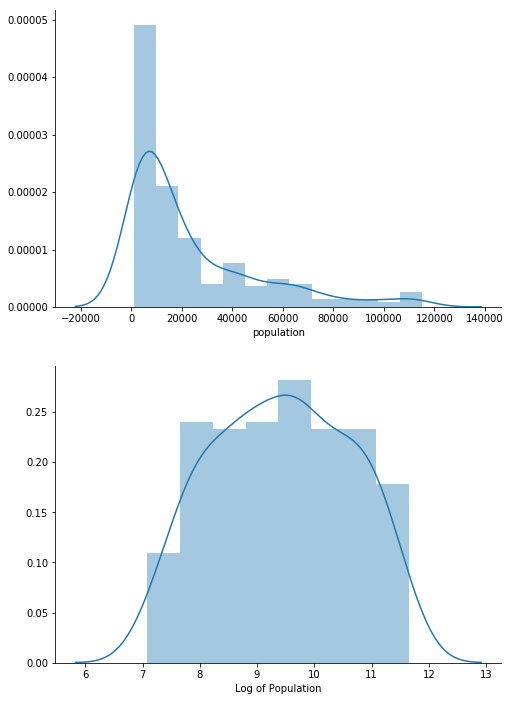

In [3]:
fig = plt.figure(figsize=(8,12))
ax1, ax2 = fig.subplots(2,1)
sns.distplot(florida_crime["population"], ax=ax1)
sns.despine(ax=ax1)
sns.distplot(np.log(florida_crime["population"]), ax=ax2)
sns.despine(ax=ax2)
ax2.set_xlabel("Log of Population")

In [3]:
# So the population variable does not look normal at all so we will need to transform it
# square
florida_crime["population_squared"] = florida_crime.population ** 2
# cube root
florida_crime["population_cube_root"] = florida_crime.population ** (1/3)
# square root
florida_crime["population_square_root"] = florida_crime.population ** (1/2)
# log
florida_crime["population_log"] = np.log(florida_crime.population)
# groups
florida_crime["population_group"] = florida_crime.population.apply(get_population_group)
florida_crime["population_group_spaced"] = florida_crime.population.apply(get_population_group_spaced)

So all crime metrics exhibit left skewness (my suspicion is population is quite correlated with each of these stats, and that is also quite left skewed however log transforming the population variable significantly reduces this skewness so lets log transform all of these as well.

## Log-transform
We are going to log-transform all of our crime stats, but since we cannot take the log of zero, we are going to add 1 to each row first.

In [4]:
offset = 1#e-10
florida_crime["robbery_log"] = np.log(florida_crime["robbery"].apply(lambda x: x + offset))
florida_crime["murder_log"] = np.log(florida_crime["murder"].apply(lambda x: x + offset))
florida_crime["violent_crime_log"] = np.log(florida_crime["violent_crime"].apply(lambda x: x + offset))
florida_crime["rape_log"] = np.log(florida_crime["rape"].apply(lambda x: x + offset))
florida_crime["assault_log"] = np.log(florida_crime.assault.apply(lambda x: x+offset))
florida_crime["burglary_log"] = np.log(florida_crime["burglary"].apply(lambda x: x+offset))
florida_crime["larceny_theft_log"] = np.log(florida_crime.larceny_theft.apply(lambda x: x+offset))
florida_crime["motor_vehicle_theft_log"] = np.log(florida_crime.motor_vehicle_theft.apply(lambda x: x+offset))
florida_crime["arson_log"] = np.log(florida_crime.arson.apply(lambda x: x+offset))
florida_crime["property_crime_log"] = np.log(florida_crime.property_crime.apply(lambda x: x+offset))

In [5]:
# Indicator vars
florida_crime["has_larceny_theft"] = np.where(florida_crime.larceny_theft > 0, 1, 0)

## PCA

In [6]:
cols_to_combine = ['violent_crime', 'murder', 'rape', 'robbery', 
              'assault', 'burglary', 'larceny_theft', 
              'motor_vehicle_theft', 'arson']

pca = PCA(n_components=len(cols_to_combine))
pca.fit(florida_crime[cols_to_combine])
components = pca.transform(florida_crime[cols_to_combine])
components = pd.DataFrame(components)
components.columns = ["PC" + str(i+1) for i in range(0, len(cols_to_combine))]
components.index = florida_crime.index

# let;s just PCA all crimes
print("Variance explained by each component")
print(pca.explained_variance_ / pca.explained_variance_.sum())
components.corr()
var_explained = (pca.explained_variance_ / pca.explained_variance_.sum())
print("Variance Explained by first n components\n")
print("----------------------")
for i in range(1,11):
    print("{}: {}".format(i, var_explained[:i].sum()))

Variance explained by each component
[9.77917353e-01 1.69474748e-02 2.74938384e-03 1.70396416e-03
 5.87019793e-04 8.41023541e-05 6.98681829e-06 3.71478065e-06
 1.95101086e-35]
Variance Explained by first n components

----------------------
1: 0.9779173534381581
2: 0.9948648282572901
3: 0.9976142120966666
4: 0.999318176253744
5: 0.999905196046988
6: 0.9999892984010621
7: 0.9999962852193502
8: 1.0
9: 1.0
10: 1.0


In [7]:
# Create more components using the log values
log_cols = [col + "_log" for col in cols_to_combine]

pca_log = PCA(n_components=len(log_cols))
pca_log.fit(florida_crime[log_cols])
components_log = pca_log.transform(florida_crime[log_cols])
components_log = pd.DataFrame(components_log)
components_log.columns = ["PC" + str(i+1) + "_log" for i in range(0, len(log_cols))]
components_log.index = florida_crime.index

# let;s just PCA all crimes
print("Variance explained by each component")
print(pca_log.explained_variance_ / pca_log.explained_variance_.sum())
components_log.corr()
var_explained = (pca_log.explained_variance_ / pca_log.explained_variance_.sum())
print("Variance Explained by first n components\n")
print("----------------------")
for i in range(1,11):
    print("{}: {}".format(i, var_explained[:i].sum()))


Variance explained by each component
[0.87848276 0.02972373 0.02450443 0.01898948 0.01518668 0.0129062
 0.01138115 0.0078826  0.00094296]
Variance Explained by first n components

----------------------
1: 0.8784827578509263
2: 0.9082064879740145
3: 0.9327109204833408
4: 0.9517003976725013
5: 0.9668870825043581
6: 0.979793286714851
7: 0.9911744384082289
8: 0.9990570420454689
9: 1.0000000000000002
10: 1.0000000000000002


*So we only need the first 2 to 4 of the original variables, and 5-7 of the log-transformed variables.*

In [8]:
florida_crime = florida_crime.join(components.join(components_log))

In [22]:
florida_crime.head()

,population,violent_crime,murder,rape,robbery,assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,...,PC9,PC1_log,PC2_log,PC3_log,PC4_log,PC5_log,PC6_log,PC7_log,PC8_log,PC9_log
city,,,,,,,,,,,,,,,,,,,,,
Alachua,10037,40,0,4,6,30,266,45,211,10,...,1.950729e-14,-0.194424,-0.556916,0.077181,-0.368306,0.248606,-0.243008,-0.617426,-0.065408,0.010334
Altamonte Springs,43833,136,1,16,29,90,1369,147,1147,75,...,-3.345035e-14,3.481827,0.132816,-0.317853,-0.333414,-0.047684,-0.069326,-0.006622,-0.202602,-0.079807
Apalachicola,2345,3,0,0,0,3,5,1,4,0,...,3.751207e-14,-6.722004,-1.906395,0.328336,0.646919,-0.614461,-0.605279,-0.007964,0.117956,-0.090043
Apopka,50833,225,1,22,51,151,1881,350,1387,144,...,-4.977063e-14,4.798715,0.283751,-0.147093,-0.442850,-0.109208,0.121825,0.073607,0.309077,-0.089765
Arcadia,7992,71,5,4,6,56,175,82,83,10,...,3.472693e-14,0.295242,-1.518579,0.754839,0.559651,0.639694,0.504152,0.770763,0.296997,0.127491


# Split

In [9]:
train = florida_crime.sample(frac=0.7, random_state=41)
test_cities = list(set(florida_crime.index).difference(set(train.index)))
test = florida_crime.loc[test_cities,:]
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Train shape: (178, 46)
Test shape: (77, 46)


# Build Model(s)

In [10]:
formula1 = "property_crime ~ population_cube_root + PC1 + PC2 + PC3"

lm1 = smf.ols(formula=formula1, data=train).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.853e+05
Date:                Tue, 11 Dec 2018   Prob (F-statistic):               0.00
Time:                        15:32:55   Log-Likelihood:                -629.64
No. Observations:                 178   AIC:                             1269.
Df Residuals:                     173   BIC:                             1285.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              733.4941      3.168    231.554      0.000     727.242     739.746
population_cube_root     0.2915      0.123      2.378      0.018       0.050       0.533
PC1                      1.2178      0.002    773.257      0.000       1.215       1.221
PC2                     -0.2197      0.006    -35.698      0.000      -0.232      -0.208
PC3                      1.0921      0.017     64.425      0.000       1.059       1.126
==============================================================================
Omnibus:                       79.982   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1691.581
Skew:                           1.077   Prob(JB):                         0.00
Kurtosis:                      17.948   Cond. No.                     3.96e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
model2_vars = ["PC1_log", "PC2_log", 
               "PC4_log", "PC3_log", 
               "PC5_log", "PC6_log", 
               "PC7_log", "PC8_log"]
formula2 = "property_crime_log ~ " + ' + '.join(model2_vars)
lm2 = smf.ols(formula=formula2, data=train).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     property_crime_log   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.288e+04
Date:                Tue, 11 Dec 2018   Prob (F-statistic):          4.26e-231
Time:                        15:33:32   Log-Likelihood:                 245.34
No. Observations:                 178   AIC:                            -472.7
Df Residuals:                     169   BIC:                            -444.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.7189      0.005   1211.394      0.000       5.710       5.728
PC1_log        0.3678      0.001    306.712      0.000       0.365       0.370
PC2_log        0.4346      0.007     63.730      0.000       0.421       0.448
PC4_log       -0.2190      0.008    -26.436      0.000      -0.235      -0.203
PC3_log       -0.0501      0.008     -6.552      0.000      -0.065      -0.035
PC5_log        0.2462      0.009     26.921      0.000       0.228       0.264
PC6_log        0.1552      0.011     14.620      0.000       0.134       0.176
PC7_log       -0.1062      0.011     -9.675      0.000      -0.128      -0.085
PC8_log       -0.3575      0.013    -26.490      0.000      -0.384      -0.331
==============================================================================
Omnibus:                       92.863   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1068.514
Skew:                           1.608   Prob(JB):                    9.44e-233
Kurtosis:                      14.564   Cond. No.                         11.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Evaluate

In [13]:
pred = lm1.predict(test)
test["property_crime_predicted"] = pred
test["residuals"] = test["property_crime"] - test["property_crime_predicted"]

print("Performance on TRAIN set\n-------------------------")
print("RMSE: {}\n".format(round(lm1.resid.std(),2)))
print("Performance on TEST set\n-------------------------")
print("RMSE: {}".format(round(test["residuals"].std(),2)))

Performance on TRAIN set
-------------------------
RMSE: 8.34

Performance on TEST set
-------------------------
RMSE: 12.84


In [42]:
test.groupby("population_group")["residuals"].mean()

population_group
1    -0.486770
2    -0.365928
3     1.123734
4     3.905073
5   -10.130956
Name: residuals, dtype: float64

In [56]:
pred2 = lm2.predict(test)
#test["property_crime_log_predicted"] = pred2
test["property_crime_log_predicted"] = pred2
test["residuals2"] = test["property_crime_log"] - test["property_crime_log_predicted"]
print("Performance on TRAIN set\n-------------------------")
print("RMSE: {}\n".format(round(lm2.resid.std(),2)))
print("Performance on TEST set\n-------------------------")
print("RMSE: {}".format(round(test["residuals2"].std(),2)))

Performance on TRAIN set
-------------------------
RMSE: 0.13

Performance on TEST set
-------------------------
RMSE: 0.11


If we take this difference (in the predicted log values between the train and test sets) and subtract that from our predicted values for the test set (before we exponentiate it), we should get much closer property crime predictions.

In [32]:
test["property_crime_log_predicted2"] = lm2.predict(test) - 0.02
test["property_crime_predicted2"] = np.exp(test["property_crime_log_predicted2"])
test["resids2"] = test["property_crime"] - test["property_crime_predicted2"]

Because we predicted the log of property crime, we need to exponentiate:

In [41]:
print("Performance on TRAIN set\n-------------------------")
print("RMSE: {}\n".format(round(np.exp(lm2.resid).mean(),3)))

print("Performance on TEST set\n-------------------------")
print("RMSE: {}".format(round(test["resids2"].std(),2)))

Performance on TRAIN set
-------------------------
RMSE: 1.002

Performance on TEST set
-------------------------
RMSE: 67.15


In [30]:
test.groupby("population_group")["resids2"].mean()

population_group
1     2.841509
2     6.004709
3     6.826545
4    12.708370
5    73.150616
Name: resids2, dtype: float64

In [43]:
test.groupby("population_group")["residuals"].mean()

population_group
1    -0.486770
2    -0.365928
3     1.123734
4     3.905073
5   -10.130956
Name: residuals, dtype: float64

**Takeaways**: Model 1 suffers from collinear input features (as can be observed from the summary output), the R^2 value of 1.0 suggests overfitting, and there is a 53.9% change in the RMSE on the train set versus the test set.

Therefore, we first log-transform the crime input variables, and then PCA these to get principal components, of which we need at least 6. The R^2 value is still really good at 0.998, but more importantly the RMSE is only 18.2% higher on the test set.  

# Conclusions

The input features are highly correlated with each other (primarily due to each crime's dependence on the population), so we took these 9 metrics and used PCA to "combine" them into 3 principal components, log transformed the population and used these 4 variables to define our model. Due to the high R^2 value (1.0) we suspect overfitting (likely due to the collinear inputs), so we constructed a new model to predict the log of property crime. We basically repeated the above process, but this time we fed the log values to our PCA, and ended up having to use 8 8 components. While this model performed extremely well on the train set, it had a high RMSE value (67.15 compared to 12.84 for the first model). So while the primary motivation in creating the second model was to reduce collinearity among the inputs, that model still performed better on the test set. 

If we look a little deeper and break down the model performance by population group, we see that model 2 fails significantly more for really high populations than model 1. Model 1 underestimates property crime by 62%, whereas model 2 overestimates property crime over 70% of the time. 